In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
categories = np.load('/kaggle/input/timeseries/categories.npy')
categories.shape

(48000,)

In [3]:
valid_periods = np.load('/kaggle/input/timeseries/valid_periods.npy')
valid_periods.shape

(48000, 2)

In [4]:
training_data = np.load('/kaggle/input/timeseries/training_data.npy')
training_data.shape

(48000, 2776)

In [5]:
training_data_df = pd.DataFrame(training_data)
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [6]:
training_data_df = training_data_df.astype(np.float32)
training_data_df.info()
training_data_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,...,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,0.000004,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.515814,0.520281,0.528503,0.533299,0.530825,0.525855,0.522132,0.523433,0.530226,0.531927
std,0.000837,0.000813,0.000781,0.000760,0.000757,0.000749,0.000745,0.000741,0.000741,0.000733,...,0.288777,0.289387,0.287716,0.288655,0.289785,0.291925,0.296271,0.302170,0.303567,0.304784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.260870,0.265976,0.275296,0.276525,0.269440,0.259259,0.246887,0.242881,0.246772,0.244700
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.529901,0.535940,0.546886,0.556100,0.552312,0.544393,0.542242,0.550017,0.561833,0.564695
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.774056,0.781060,0.788449,0.795617,0.794872,0.793385,0.794734,0.802337,0.809368,0.815334
max,0.183319,0.178061,0.171051,0.166542,0.165793,0.164041,0.163324,0.162288,0.162288,0.160536,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
reshaped_categories = categories.reshape(-1, 1)
onehot_categories = encoder.fit_transform(reshaped_categories)

onehot_categories

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [8]:
from sklearn.model_selection import train_test_split

# Split the indices of the time series into training and validation sets
train_indices, val_indices = train_test_split(np.arange(len(training_data_df)), test_size=0.1, random_state=42, stratify=categories)

# Use these indices to create training and validation sets
train_set = training_data_df.iloc[train_indices]
valid_periods_train = valid_periods[train_indices]
onehot_categories_train = onehot_categories[train_indices]

val_set = training_data_df.iloc[val_indices]
valid_periods_val = valid_periods[val_indices]
onehot_categories_val = onehot_categories[val_indices]

train_set.shape, valid_periods_train.shape, onehot_categories_train.shape, val_set.shape, valid_periods_val.shape, onehot_categories_val.shape

((43200, 2776), (43200, 2), (43200, 6), (4800, 2776), (4800, 2), (4800, 6))

In [9]:
def calculate_padding_length(sq, w, t, s):
    cycle = w + t
    if sq <= cycle: return cycle - sq
    else:
        m = (sq - cycle) % s
        if m == 0: return m
        else: return s - m

In [10]:
def create_sequences(df, valid_periods, categories, window, telescope, stride):

    input_sequences = []
    input_categories = []
    output_sequences = []
    

    for i in range(len(valid_periods)):
        start, end = valid_periods[i]
        category = categories[i]
        
        sequence = df.iloc[i, start:end].values
        
        padding_length = calculate_padding_length(len(sequence), window, telescope, stride)
        sequence = np.pad(sequence, (padding_length, 0), mode='constant', constant_values=0)

        for j in range(0, len(sequence) - window - telescope + 1, stride):
            input_seq = sequence[j:(j + window)]
            output_seq = sequence[(j + window):(j + window + telescope)]
            
            input_sequences.append(input_seq)
            input_categories.append(category)
            output_sequences.append(output_seq)

    return np.array(input_sequences), np.array(input_categories), np.array(output_sequences)

In [11]:
window = 200
telescope = 18
stride = 5

In [12]:
X_train, X_train_category, y_train = create_sequences(train_set, valid_periods_train, onehot_categories_train, window, telescope, stride)
X_val, X_val_category, y_val = create_sequences(val_set, valid_periods_val, onehot_categories_val, window, telescope, stride)
X_train.shape, X_train_category.shape, y_train.shape, X_val.shape, X_val_category.shape, y_val.shape

((431642, 200),
 (431642, 6),
 (431642, 18),
 (49243, 200),
 (49243, 6),
 (49243, 18))

In [13]:
import tensorflow as tf

In [14]:
# https://pylessons.com/transformers-introduction
def positional_encoding(length: int, depth: int):
    """
    Generates a positional encoding for a given length and depth.

    Args:
        length (int): The length of the input sequence.
        depth (int): The depth that represents the dimensionality of the encoding.

    Returns:
        tf.Tensor: The positional encoding of shape (length, depth).
    """
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

(100, 128)


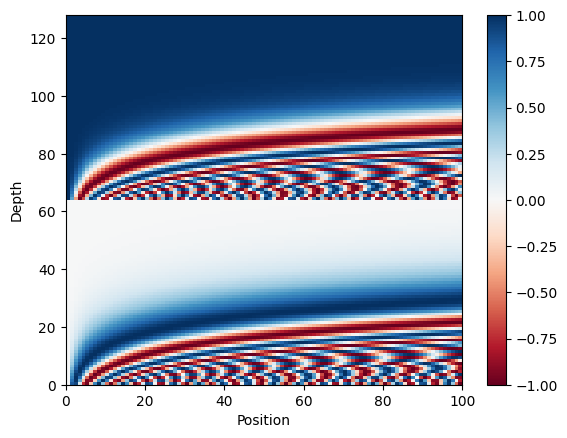

In [15]:
import matplotlib.pyplot as plt

pos_encoding = positional_encoding(length=100, depth=128)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

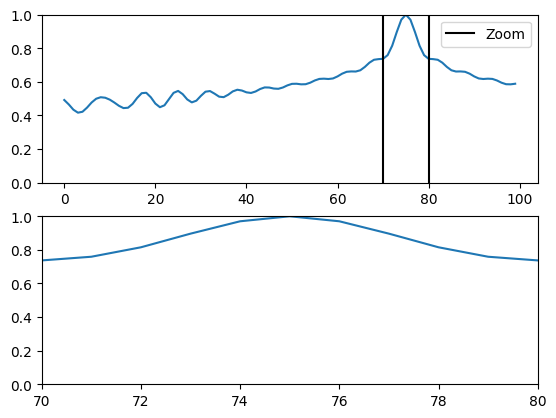

In [16]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[75]
dots = tf.einsum('pd,d->p', pos_encoding, p).numpy()

plt.subplot(2, 1, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([70, 70, float('nan'), 80, 80], [0, 1, float('nan'), 0, 1], color='k', label='Zoom')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(len(dots)), dots)
plt.xlim([70, 80])
plt.ylim([0, 1])

In [17]:
class PositionalEncoding(tf.keras.layers.Layer):
    """
    A positional encoding layer with a positional encoding that helps the Transformer
    to understand the relative position of the inputs. 

    Methods:
        call: Performs the forward pass of the layer.
    """
    
    def __init__(self, max_length: int, d_model: int):
        """
        Args:
            max_length (int): The size of the maximum input sequence.
            d_model (int): The dimensionality of the pos encoding.
        """
        super().__init__()
        self.max_length = max_length
        self.d_model = d_model
        self.pos_encoding = positional_encoding(length=max_length, depth=d_model)
        
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """ Performs the forward pass of the layer.
        
        Args:
            x (tf.Tensor): The input tensor of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence with added positional information. The shape is
                (batch_size, seq_length, d_model).
        """
        length = tf.shape(x)[1]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout, Add

class TimeSeriesSelfAttention(Layer):
    """
    Implements a self-attention mechanism specifically for time series data. The attention mechanism allows each point in 
    the sequence to attend to all other points in the same sequence, capturing the global dependencies within the time series.

    Attributes:
        mha (MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (LayerNormalization): The LayerNormalization layer.
        dropout (Dropout): The Dropout layer to prevent overfitting.
        add (Add): The Add layer to combine inputs and attention outputs.
    """
    def __init__(self, d_model, num_heads, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)
        self.add = Add()

    def call(self, inputs, training=False):
        # Self-attention
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout(attn_output, training=training)
        # Add & Norm
        out = self.layernorm(self.add([inputs, attn_output]))
        return out

In [19]:
class FeedForward(Layer):
    """
    A class that implements the feed-forward layer.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        seq (tf.keras.Sequential): The sequential layer that contains the feed-forward layers. It applies the two feed-forward layers and the dropout layer.
        add (tf.keras.layers.Add): The Add layer.
        layer_norm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
    """
    def __init__(self, d_model: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the FeedForward layer.

        Args:
            d_model (int): The dimensionality of the model.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the feed-forward operation. 

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Encoder. Usually there are multiple layers stacked on top of each other.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        self_attention (GlobalSelfAttention): The global self-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the EncoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.self_attention = TimeSeriesSelfAttention(
            num_heads=num_heads,
            d_model=d_model,
            dropout_rate=dropout_rate
            )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [21]:
class Encoder(Layer):
    """
    A custom TensorFlow layer that implements the Encoder.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the encoder.
        pos_encoding (Positionalncoding): The positional encoding layer.
        enc_layers (list): The list of encoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, max_length: int, dropout_rate: float=0.1):
        """
        Constructor of the Encoder.

        Args:
            num_layers (int): The number of layers in the encoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            max_length (int): The size of the max input sequence.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_encoding = PositionalEncoding(max_length=max_length, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.
        
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.pos_encoding(x)  
        # here x has shape `(batch_size, seq_len, d_model)`

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [22]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Reshape, RepeatVector

def TimeSeriesTransformer(
    num_layers: int = 4, 
    d_model: int = 32, 
    num_heads: int = 8,
    dff: int = 128,
    window: int = window,
    telescope: int = telescope,
    num_categories: int = 6,
    dropout_rate: float = 0.1
) -> tf.keras.Model:
    """
    A custom TensorFlow model for time series forecasting using Transformer architecture with categorical inputs.
    """
   # Inputs
    time_series_input = Input(shape=(window, 1), dtype=tf.float32)  # Shape: (batch_size, window, 1)
    categorical_input = Input(shape=(num_categories,), dtype=tf.float32)  # Shape: (batch_size, num_categories)

    # Process Time Series Input
    ts_processed = Dense(d_model, activation='relu')(time_series_input)  # Shape: (batch_size, window, d_model)

    # Process Categorical Input
    cat_processed = Dense(d_model, activation='relu')(categorical_input)  # Shape: (batch_size, d_model)
    cat_processed = RepeatVector(window)(cat_processed)  # Shape: (batch_size, window, d_model)

    # Combine Time Series and Categorical Data
    combined_input = Concatenate(axis=-1)([ts_processed, cat_processed])  # Shape: (batch_size, window, 2*d_model)

    # Encoder
    encoder_output = Encoder(num_layers, 2*d_model, num_heads, dff, window, dropout_rate)(combined_input)  # Adjusted d_model to 2*d_model

    # Output Layer
    output = Dense(telescope)(encoder_output[:, -1, :])  # Predicting 'telescope' future values

    return tf.keras.Model(inputs=[time_series_input, categorical_input], outputs=output)

In [23]:
model = TimeSeriesTransformer()

In [24]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 32)                   224       ['input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 200, 32)              64        ['input_1[0][0]']             
                                                                                              

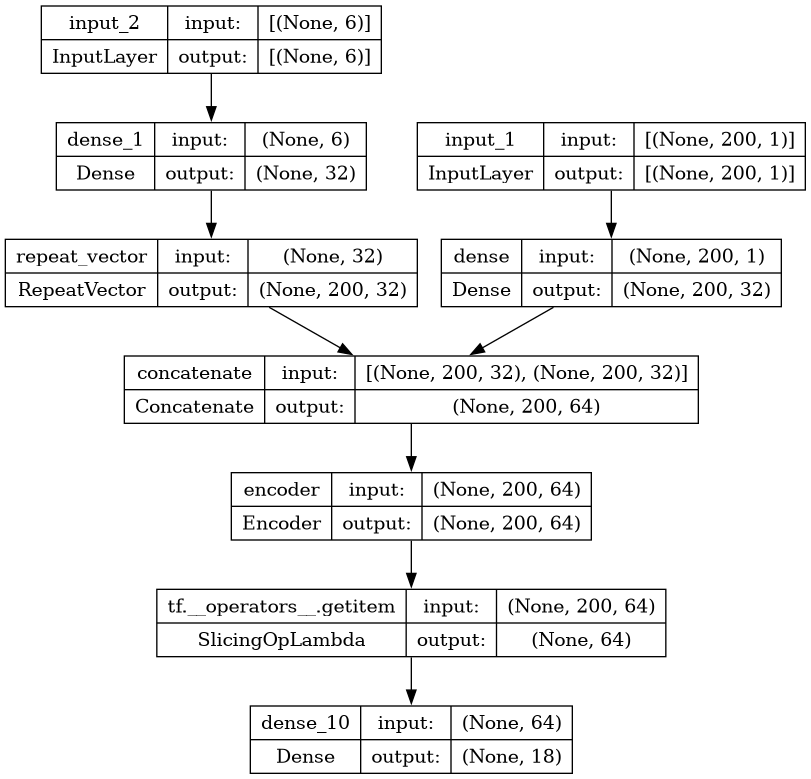

In [25]:
model.summary()

from tensorflow import keras as tfk
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [26]:
batch_size = 64
epochs = 200

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    mode='min', 
    patience=5, 
    factor=0.1, 
    min_lr=1e-5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min"
)

history = model.fit(
    x = [X_train, X_train_category],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ([X_val, X_val_category], y_val),
    callbacks = [
        early_stopping,
        reduce_lr,
        checkpoint
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
preds = model.predict([X_val, X_val_category])
preds.shape

In [ ]:
from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(y_val, np.squeeze(preds))
mse

In [ ]:
def plot_with_training(y_train, y_true, y_pred, num_samples=3):
    """Plot the training, true, and predicted values for a random sample of sequences."""
    sample_indices = np.random.choice(np.arange(len(y_true)), num_samples, replace=False)

    for i, index in enumerate(sample_indices, 1):
        plt.figure(figsize=(12, 4))

        # Plot the training part (first 200 points)
        plt.plot(y_train[index].flatten(), label='Training Values', color='blue')

        # Plot the true values (next 18 points)
        true_start_index = len(y_train[index])
        plt.plot(range(true_start_index, true_start_index + len(y_true[index])),
                 y_true[index].flatten(), label='True Values', color='green')

        # Plot the predicted values (next 18 points)
        plt.plot(range(true_start_index, true_start_index + len(y_pred[index])),
                 y_pred[index].flatten(), label='Predicted Values', linestyle='--', color='red')

        plt.title(f'Sequence {i} - Training, True vs Predicted')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

In [ ]:
plot_with_training(X_val, y_val, preds)

In [ ]:
model.save('transformer_deep_final')

In [ ]:
!zip -r transformer_deep_final.zip /kaggle/working/transformer_deep_final

In [ ]:
!zip -r best.zip /kaggle/working/best